In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from src.metrics import calculate_hypervolume
import importlib
import src.optimizer
importlib.reload(src.optimizer)
from src.optimizer import Optimizer
import src.ISPEA2Optimizer
importlib.reload(src.ISPEA2Optimizer)
from src.ISPEA2Optimizer import ISPEA2Optimizer
from src.network_creator import NetworkCreator
import random
import pandas as pd

In [29]:
def plot_hv_over_evaluations(hv_nsga2_all, hv_ispea2_all, generations, network_name):
    """
    Rysuje wykres średniej wartości hypervolume na przestrzeni generacji.
    - hv_nsga2_all, hv_ispea2_all: listy list (runs x generations)
    """
    hv_nsga2_mean = np.mean(hv_nsga2_all, axis=0)
    hv_nsga2_std = np.std(hv_nsga2_all, axis=0)

    hv_ispea2_mean = np.mean(hv_ispea2_all, axis=0)
    hv_ispea2_std = np.std(hv_ispea2_all, axis=0)

    x = np.arange(1, generations+1)

    plt.figure(figsize=(10,6))
    plt.plot(x, hv_nsga2_mean, label='NSGA-II', color='blue')
    plt.fill_between(x, hv_nsga2_mean - hv_nsga2_std, hv_nsga2_mean + hv_nsga2_std, alpha=0.2, color='blue')

    plt.plot(x, hv_ispea2_mean, label='ISPEA2', color='orange')
    plt.fill_between(x, hv_ispea2_mean - hv_ispea2_std, hv_ispea2_mean + hv_ispea2_std, alpha=0.2, color='orange')

    plt.xlabel("Number of generations")
    plt.ylabel("Hypervolume (HV)")
    plt.title(f"Hypervolume over Generations for {network_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

import time

def run_experiment(network, start_node, end_node, population_size, generations, reference_point, runs=5):
    hv_nsga2_all = []
    hv_ispea2_all = []
    times_nsga2 = []
    times_ispea2 = []

    for i in range(runs):
        seed = 100 + i
        random.seed(seed)
        np.random.seed(seed)

        nsga2_opt = Optimizer(start_node, end_node, network, population_size, 0.2, 0.3, generations)
        ispea2_opt = ISPEA2Optimizer(start_node, end_node, network, population_size, 0.2, 0.3, generations)

        def transform(front):
            for ind in front:
                ind.metrics = [-ind.metrics[0], ind.metrics[1], ind.metrics[2]]
            return front

        start = time.time()
        fronts_nsga2 = nsga2_opt.nsga2_full_trace()
        time_nsga2 = time.time() - start

        start = time.time()
        fronts_ispea2 = ispea2_opt.run_full_trace()
        time_ispea2 = time.time() - start

        times_nsga2.append(time_nsga2)
        times_ispea2.append(time_ispea2)

        hv_nsga2 = [calculate_hypervolume(transform(front), reference_point) for front in fronts_nsga2]
        hv_ispea2 = [calculate_hypervolume(transform(front), reference_point) for front in fronts_ispea2]

        hv_nsga2_all.append(hv_nsga2)  # zamiast .append(hv_nsga2[-1])
        hv_ispea2_all.append(hv_ispea2)

    return hv_nsga2_all, hv_ispea2_all, times_nsga2, times_ispea2


def run_all():
    reference_point = [0, 1000, 1.0]
    generations = 10
    runs = 5

    sizes = [1, 5, 10]
    networks = {
        "full_mesh_20": NetworkCreator().create_full_mesh_network(20),
        "full_mesh_40": NetworkCreator().create_full_mesh_network(40),
        "polska": NetworkCreator("network_source/polska_v2").create_physical_network(),
        "janos-us-ca": NetworkCreator("network_source/janos-us-ca").create_physical_network(),
        "germany": NetworkCreator("network_source/germany-50_v2").create_physical_network()
    }

    start_node = "1"
    end_node = "2"
    start_nodes = {
        "polska":"Warsaw",
        "janos-us-ca": "SanFrancisco",
        "germany": "Aachen"
    }
    end_nodes = {
        "polska":"Gdansk",
        "janos-us-ca": "NewYork",
        "germany": "Berlin"
    }

    results = []

    for net_name, net in networks.items():
        for size in sizes:
            
            print(f"\n[RUN] Network: {net_name}, Pop Size: {size}")
            s_node = start_node if "full" in net_name else start_nodes[net_name]
            e_node = end_node if "full" in net_name else end_nodes[net_name]

            hv_nsga2_all, hv_ispea2_all, times_nsga2, times_ispea2 = run_experiment(net, s_node, e_node, size, generations, reference_point, runs)
            plot_hv_over_evaluations(hv_nsga2_all, hv_ispea2_all, generations, f"{net_name} (Pop={size})")

            results.append({
                "Algorithm": "NSGA-II",
                "Network": net_name,
                "PopSize": size,
                "HV Mean": np.mean(hv_nsga2_all),
                "HV Std": np.std(hv_nsga2_all),
                "Time [s]": np.mean(times_nsga2)
            })

            results.append({
                "Algorithm": "ISPEA2",
                "Network": net_name,
                "PopSize": size,
                "HV Mean": np.mean(hv_ispea2_all),
                "HV Std": np.std(hv_ispea2_all),
                "Time [s]": np.mean(times_ispea2)
            })

    df_results = pd.DataFrame(results)
    
    return df_results




In [30]:
def plot_results_bar(df_results):
    networks = df_results["Network"].unique()
    pop_sizes = df_results["PopSize"].unique()
    
    fig, ax = plt.subplots(figsize=(12, 6))

    width = 0.35
    x = np.arange(len(networks) * len(pop_sizes))

    nsga2_means = []
    ispea2_means = []
    labels = []

    for net in networks:
        for pop in pop_sizes:
            row_nsga2 = df_results[(df_results["Network"] == net) & 
                                   (df_results["PopSize"] == pop) & 
                                   (df_results["Algorithm"] == "NSGA-II")]
            row_ispea2 = df_results[(df_results["Network"] == net) & 
                                    (df_results["PopSize"] == pop) & 
                                    (df_results["Algorithm"] == "ISPEA2")]
            nsga2_means.append(float(row_nsga2["HV Mean"].iloc[0]))
            ispea2_means.append(float(row_ispea2["HV Mean"].iloc[0]))
            labels.append(f"{net}\nPop={pop}")

    ax.bar(x - width / 2, nsga2_means, width, label='NSGA-II')
    ax.bar(x + width / 2, ispea2_means, width, label='ISPEA2')

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel("Mean Hypervolume (HV)")
    ax.set_title("Porównanie średnich HV dla NSGA-II i ISPEA2")
    ax.legend()
    ax.grid(axis='y')

    plt.tight_layout()
    plt.show()




[RUN] Network: full_mesh_20, Pop Size: 1


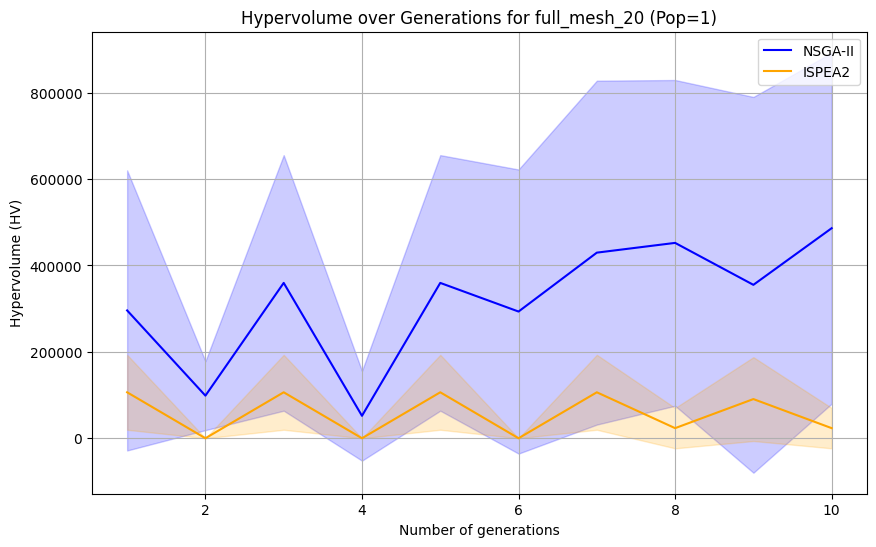


[RUN] Network: full_mesh_20, Pop Size: 5


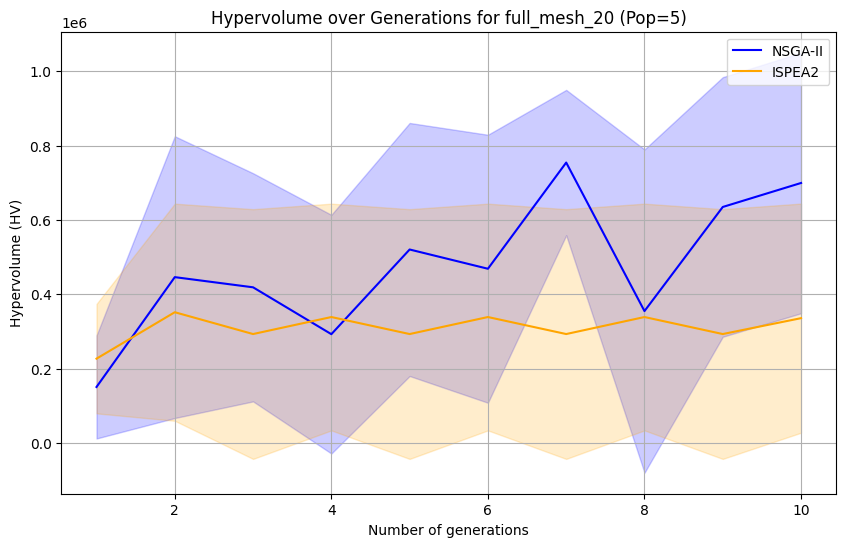


[RUN] Network: full_mesh_20, Pop Size: 10


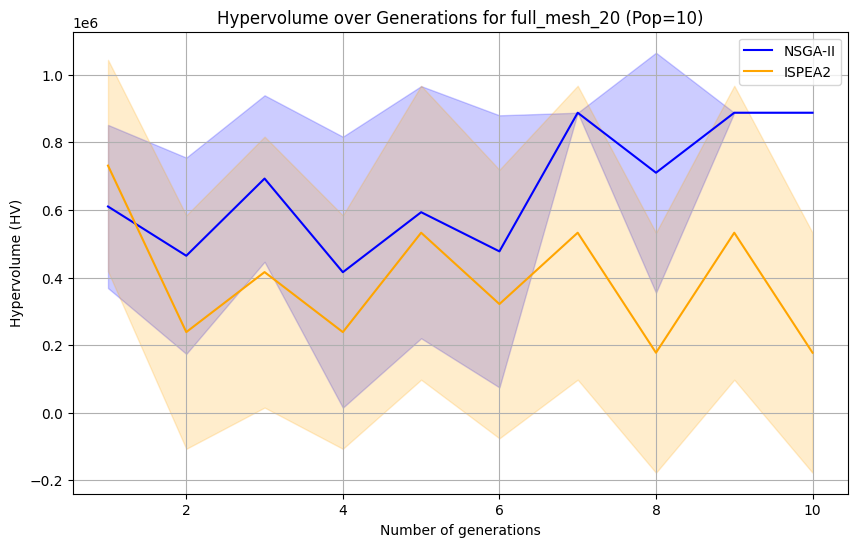


[RUN] Network: full_mesh_40, Pop Size: 1


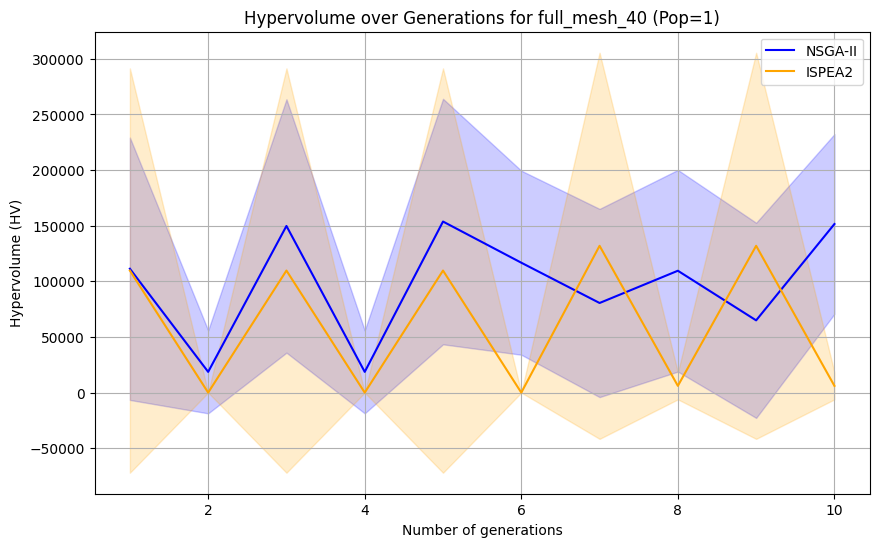


[RUN] Network: full_mesh_40, Pop Size: 5


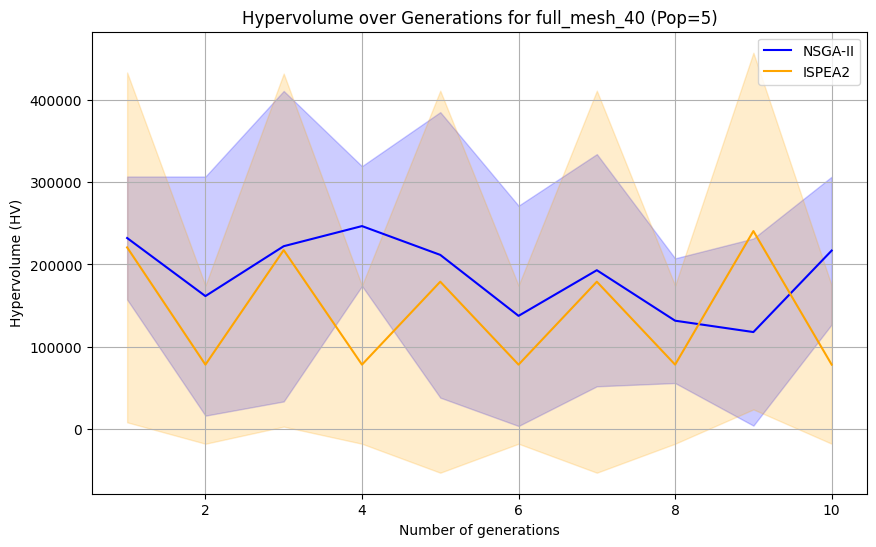


[RUN] Network: full_mesh_40, Pop Size: 10


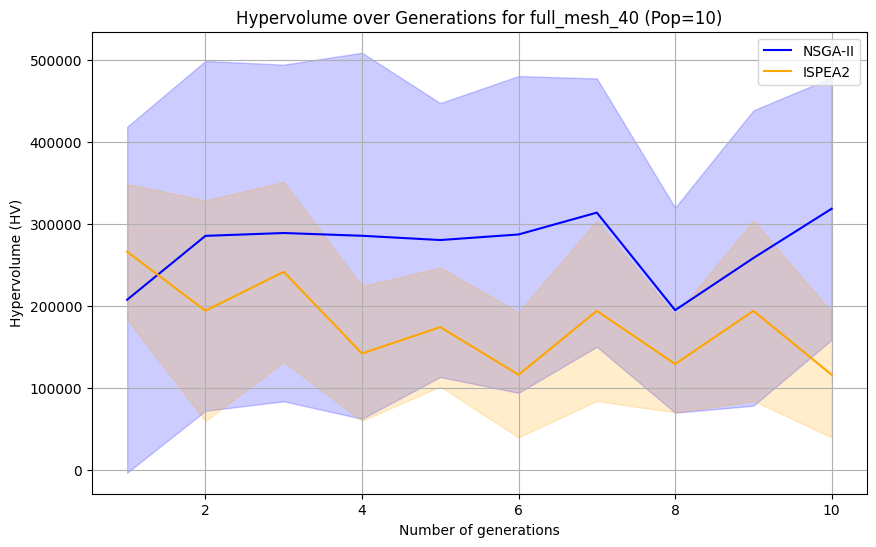


[RUN] Network: polska, Pop Size: 1


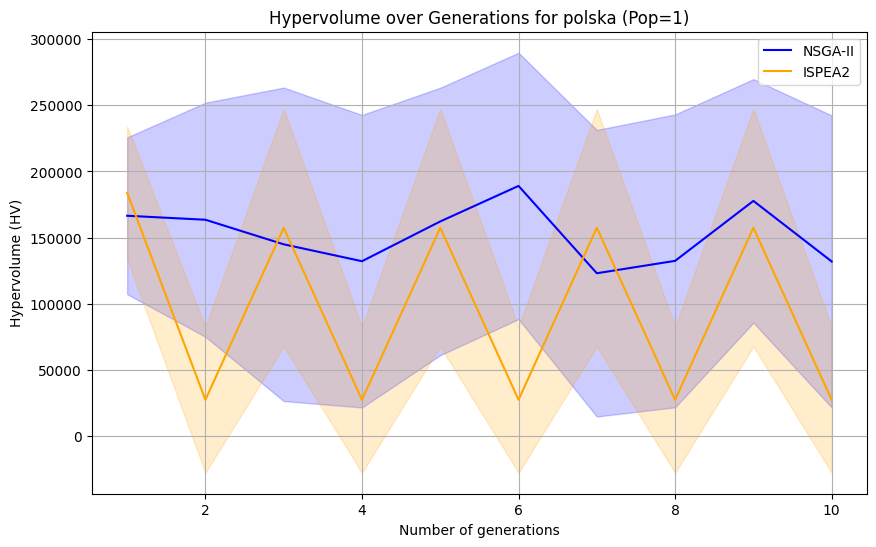


[RUN] Network: polska, Pop Size: 5


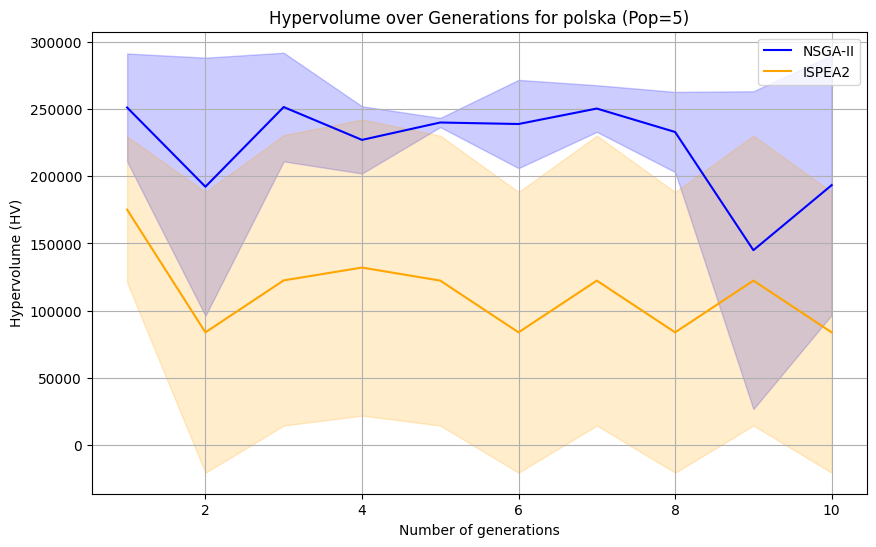


[RUN] Network: polska, Pop Size: 10


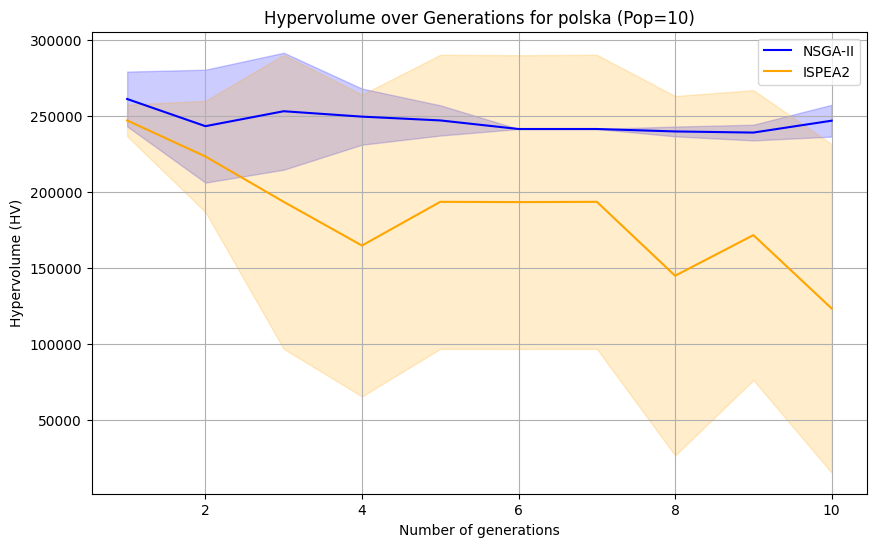


[RUN] Network: janos-us-ca, Pop Size: 1


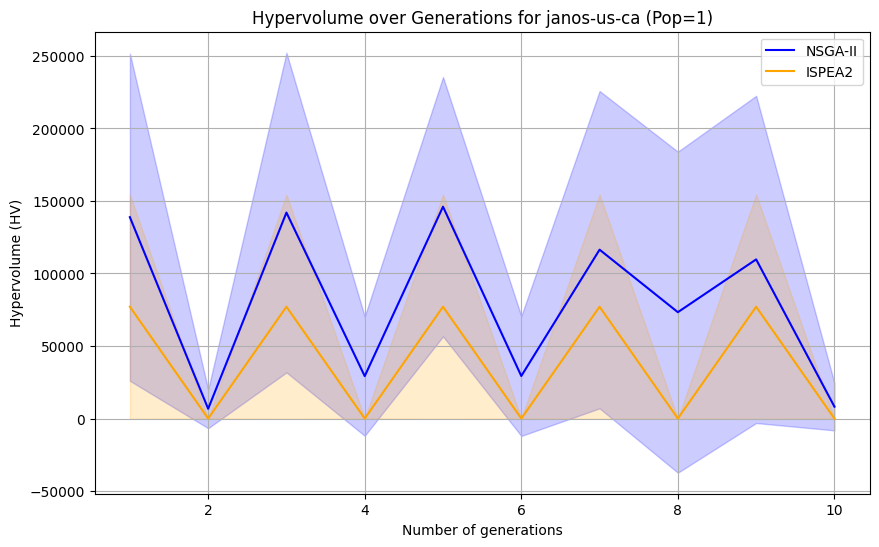


[RUN] Network: janos-us-ca, Pop Size: 5


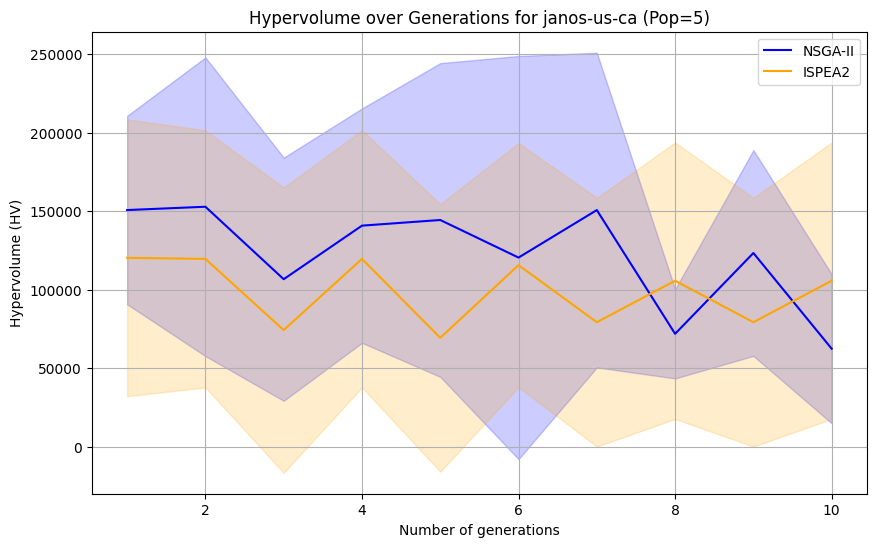


[RUN] Network: janos-us-ca, Pop Size: 10


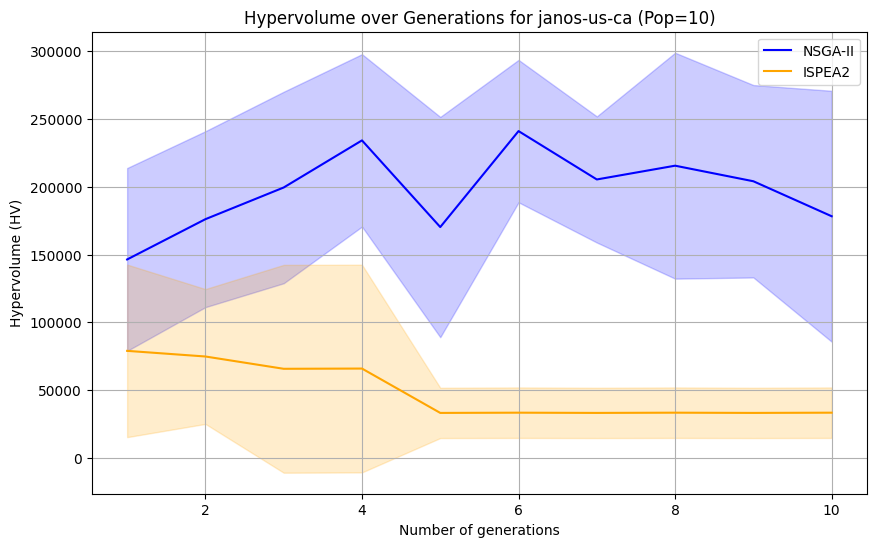


[RUN] Network: germany, Pop Size: 1


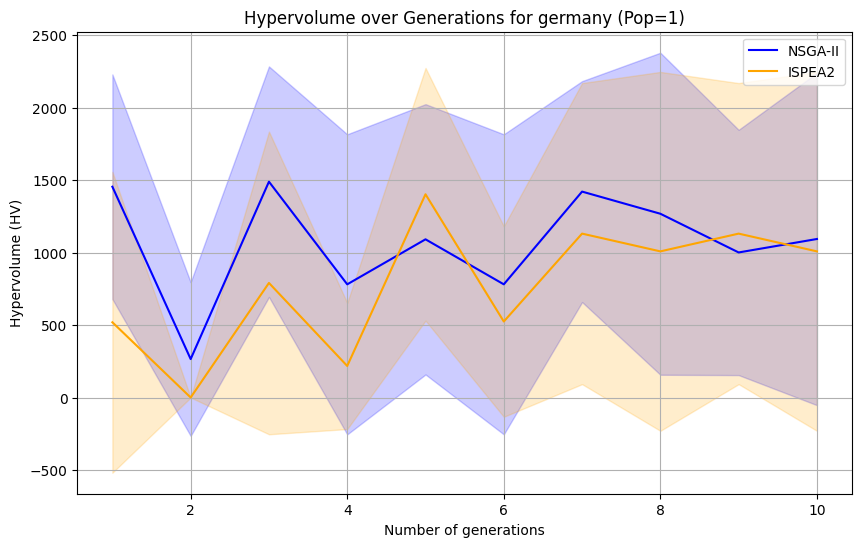


[RUN] Network: germany, Pop Size: 5


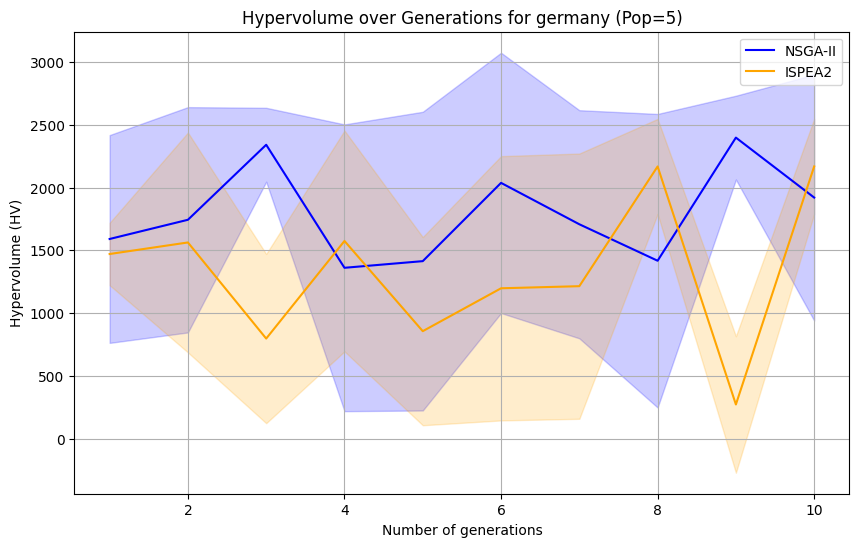


[RUN] Network: germany, Pop Size: 10


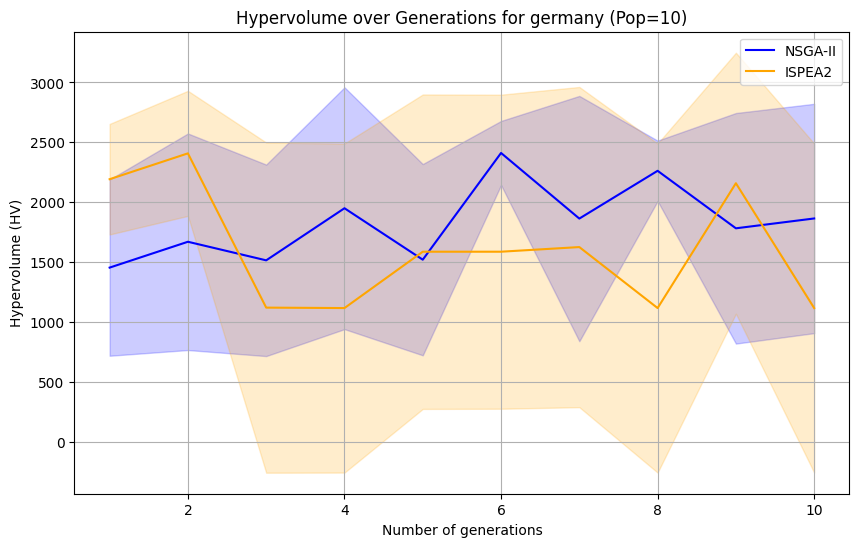

In [31]:
df=run_all()


In [32]:
df_results = df.sort_values(by=["Algorithm", "PopSize"])  # Sortowanie najpierw po algorytmie, potem po liczbie populacji
    
print(df_results.to_string(index=False))  # czytelniejszy widok w konsoli

Algorithm      Network  PopSize      HV Mean        HV Std  Time [s]
   ISPEA2 full_mesh_20        1  56281.14018  81705.168644  0.003182
   ISPEA2 full_mesh_40        1  60515.73996 139262.472006  0.011466
   ISPEA2       polska        1  95136.28460  98015.350861  0.000069
   ISPEA2  janos-us-ca        1  38535.82220  66857.355087  0.002222
   ISPEA2      germany        1    772.93704   1027.677687  0.002010
   ISPEA2 full_mesh_20        5 310538.90330 307477.508720  0.033877
   ISPEA2 full_mesh_40        5 142842.95042 183302.460369  0.078303
   ISPEA2       polska        5 113155.84560 106546.645039  0.041556
   ISPEA2  janos-us-ca        5  98782.55648  86440.504470  0.031045
   ISPEA2      germany        5   1328.43072    928.932182  0.032990
   ISPEA2 full_mesh_20       10 389878.12920 423484.094072  0.099161
   ISPEA2 full_mesh_40       10 176479.91358 105949.964761  0.258582
   ISPEA2       polska       10 184793.26920  97491.029578  0.123134
   ISPEA2  janos-us-ca       10  4

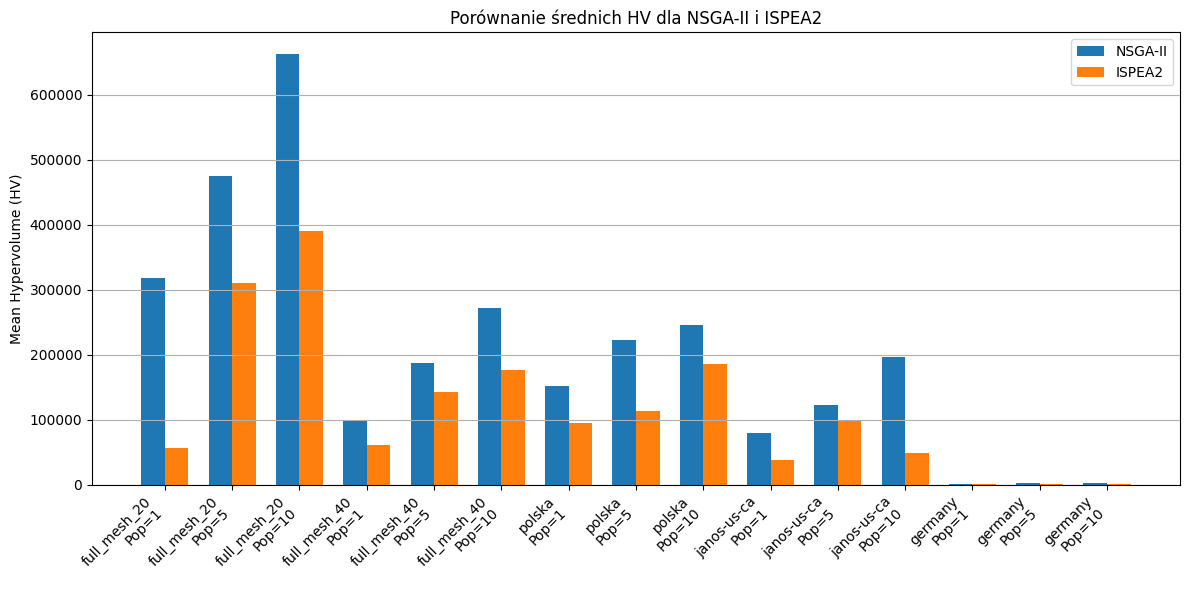

In [33]:
plot_results_bar(df)